In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Import datasets of energy data 
df=pd.read_csv('energy_dataset.csv')
#df2=pd.read_csv('weather_features.csv')

In [31]:
df.sample(10)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
3921,2015-06-13 10:00:00+02:00,487.0,977.0,0.0,4454.0,6577.0,259.0,0.0,0.0,0.0,...,279.0,0.0,1781.0,2773.0,NaN,1747.0,27780.0,27908.0,62.19,70.45
26387,2018-01-04 11:00:00+01:00,243.0,0.0,0.0,3227.0,975.0,188.0,0.0,0.0,0.0,...,306.0,0.0,5276.0,3659.0,NaN,5304.0,26273.0,25876.0,28.30,57.08
2773,2015-04-26 14:00:00+02:00,401.0,0.0,0.0,4754.0,2561.0,263.0,0.0,0.0,0.0,...,158.0,0.0,6880.0,2113.0,NaN,6701.0,25034.0,25495.0,37.52,57.98
16572,2016-11-21 12:00:00+01:00,326.0,877.0,0.0,6062.0,4982.0,277.0,0.0,0.0,0.0,...,269.0,0.0,10380.0,1085.0,NaN,10412.0,33933.0,34284.0,48.29,55.72
32227,2018-09-04 20:00:00+02:00,199.0,0.0,0.0,5426.0,2119.0,316.0,0.0,0.0,0.0,...,320.0,0.0,7260.0,222.0,NaN,7528.0,32510.0,32422.0,51.95,82.74
5841,2015-09-01 10:00:00+02:00,539.0,933.0,0.0,6915.0,8229.0,360.0,0.0,0.0,0.0,...,236.0,0.0,3438.0,1825.0,NaN,3357.0,37861.0,37381.0,75.69,68.43
1482,2015-03-03 18:00:00+01:00,419.0,0.0,0.0,7094.0,4376.0,325.0,0.0,0.0,0.0,...,225.0,0.0,2469.0,1167.0,NaN,2459.0,31291.0,30668.0,55.49,72.35
17415,2016-12-26 15:00:00+01:00,335.0,812.0,0.0,4313.0,4725.0,270.0,0.0,0.0,0.0,...,271.0,0.0,3091.0,2956.0,NaN,3046.0,26434.0,25394.0,49.29,60.15
25786,2017-12-10 10:00:00+01:00,368.0,641.0,0.0,7489.0,6181.0,308.0,0.0,0.0,0.0,...,354.0,0.0,1402.0,2018.0,NaN,1451.0,24553.0,25409.0,64.05,58.78
31504,2018-08-05 17:00:00+02:00,363.0,0.0,0.0,5623.0,2344.0,288.0,0.0,0.0,0.0,...,280.0,0.0,5833.0,2983.0,NaN,5435.0,30405.0,30121.0,55.44,70.89


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [3]:
# Transform the feature 'time' from iso-8601 format to pandas datetime64. 
df['time'] = df['time'].apply(lambda x: pd.Timestamp.fromisoformat(x))


In [38]:
# Check how the time column appears now.
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [44]:
# Check the data type of 'time'. The output results to be an indication that it is a datatime64 for nonosecon precision. 
df['time'].dtype

dtype('<M8[ns]')

In [8]:
# Check missing values
df.isnull().sum()/len(df)*100

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil coal-derived gas               0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation fossil oil shale                      0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation marine                                0.054187
generation nuclear                               0.048483
generation other                                 0.051335
generation oth

# Time series forecast: predict price of energy

For simplicity of the analysis, I will focus on analysing and predicting the average price per day in year 2018.  The time information is then removed and only observations from the year 2018 are retained.

In [4]:
# Create a dataframe with the selected features. 
forecast_df= df[['time', 'price actual']]

In [5]:
forecast_df.head()

,time,price actual
0,2015-01-01 00:00:00,65.41
1,2015-01-01 01:00:00,64.92
2,2015-01-01 02:00:00,64.48
3,2015-01-01 03:00:00,59.32
4,2015-01-01 04:00:00,56.04


In [6]:
#years_to_keep = [2017, 2018]
#forecast_df = forecast_df[forecast_df['time'].dt.year.isin(years_to_keep)]

In [5]:
#Extract the year. 
forecast_df = forecast_df[forecast_df['time'].dt.year == 2018]

In [6]:
forecast_df.head()

,time,price actual
26304,2018-01-01 00:00:00,20.76
26305,2018-01-01 01:00:00,19.02
26306,2018-01-01 02:00:00,17.90
26307,2018-01-01 03:00:00,20.88
26308,2018-01-01 04:00:00,18.83


In [7]:
# Remove the time.
forecast_df['Date'] = forecast_df['time'].dt.date

In [8]:
forecast_df.head()

,time,price actual,Date
26304,2018-01-01 00:00:00,20.76,2018-01-01
26305,2018-01-01 01:00:00,19.02,2018-01-01
26306,2018-01-01 02:00:00,17.90,2018-01-01
26307,2018-01-01 03:00:00,20.88,2018-01-01
26308,2018-01-01 04:00:00,18.83,2018-01-01


In [9]:
# Group by date and find average price per day. 
forecast_df=forecast_df.groupby(['Date'])['price actual'].mean().reset_index()

In [10]:
forecast_df.shape

(365, 2)

In [11]:
forecast_df.head()

,Date,price actual
0,2018-01-01,21.042500
1,2018-01-02,47.864583
2,2018-01-03,46.862083
3,2018-01-04,44.930417
4,2018-01-05,50.742917


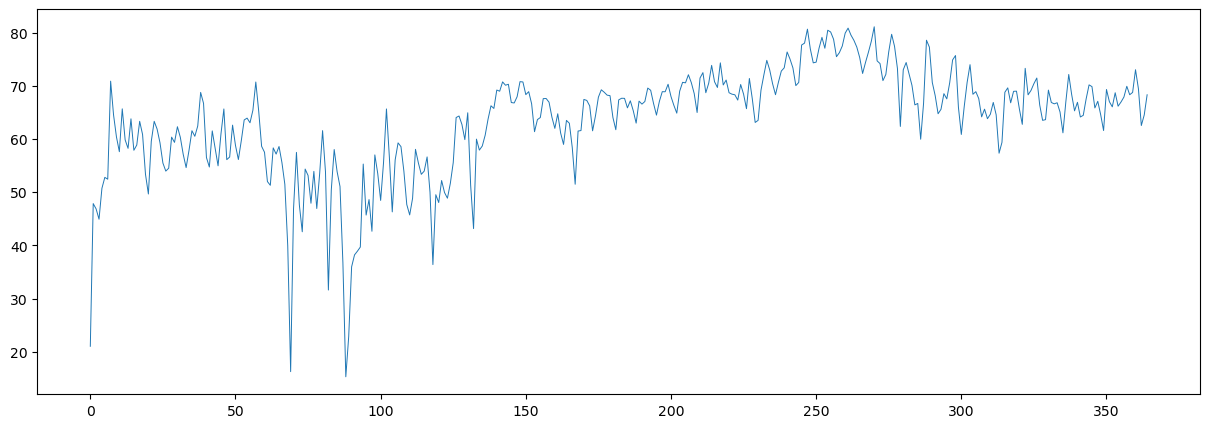

In [12]:
# Plot actual price. 
plt.figure(figsize=(15,5))
forecast_df['price actual'].plot(kind='line', lw=0.7);

In [13]:
#Check if the data is stationary. The data results non stationary.
adfuller(forecast_df["price actual"])

(-1.7514422332447552,
 0.4048215506882066,
 12,
 352,
 {'1%': -3.4490648539347544,
  '5%': -2.8697861692116478,
  '10%': -2.5711631253228306},
 2062.6300937287706)

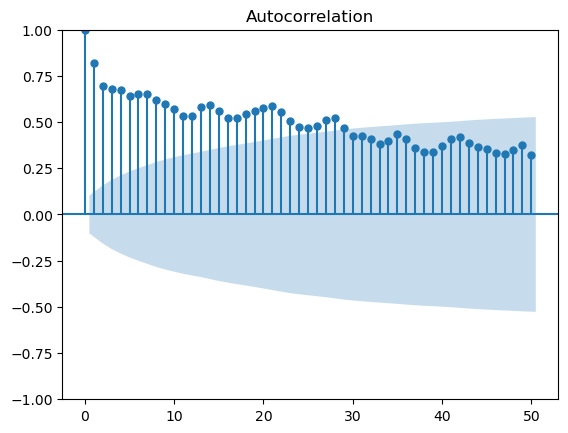

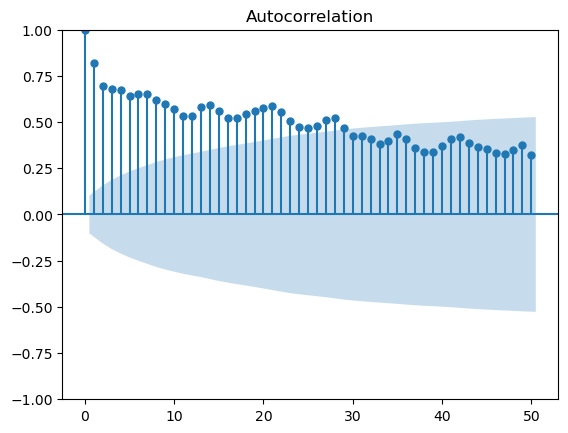

In [16]:
# Plot ACF. 
plot_acf(forecast_df["price actual"], lags=50)

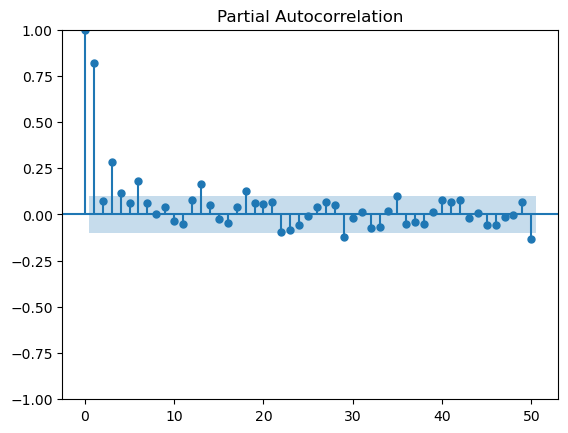

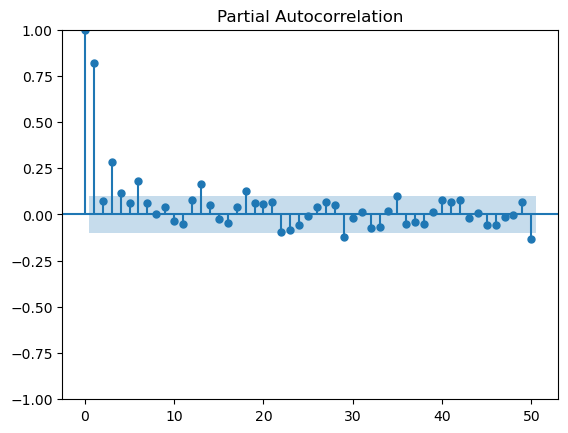

In [17]:
plot_pacf(forecast_df["price actual"], method='ywm', lags=50)

In [18]:
# Splitting the data into training and testing sets
train_size = 0.8  
train, test = train_test_split(forecast_df['price actual'], train_size=train_size, shuffle=False)


# Print the sizes of the training and testing sets
print("Train set size:", len(train))
print("Test set size:", len(test))

Train set size: 292
Test set size: 73


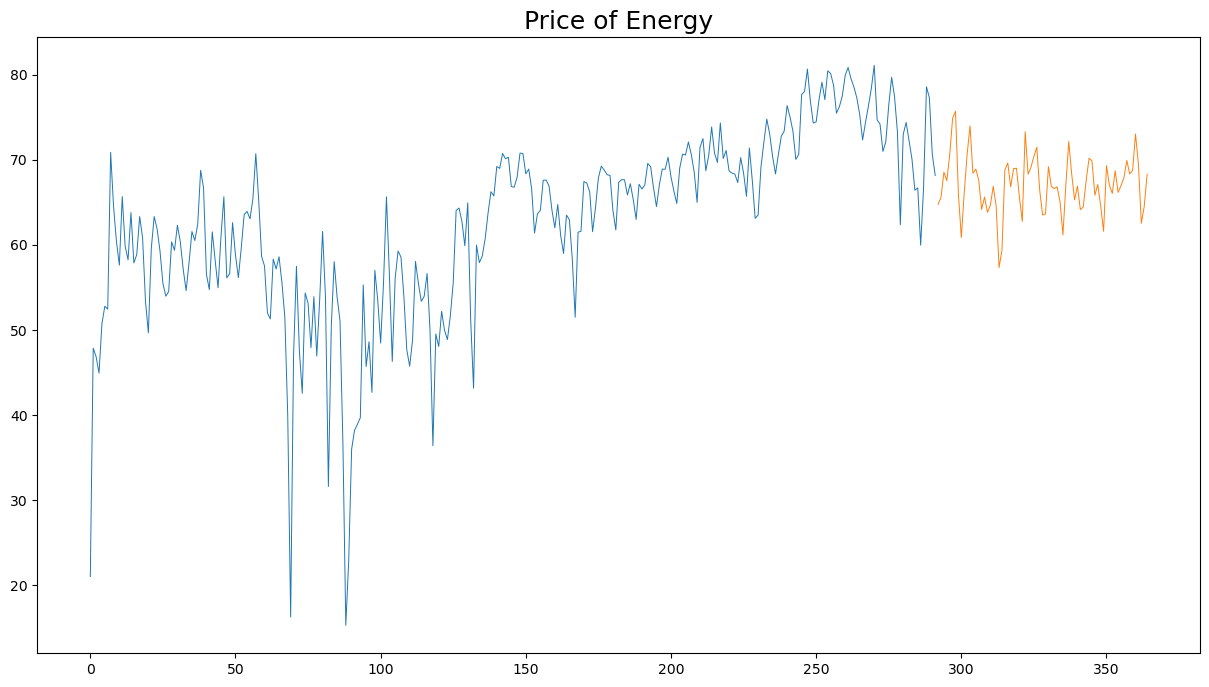

In [19]:
train.plot(figsize=(15,8), lw=0.7)
test.plot(figsize=(15,8), lw=0.7)
plt.title('Price of Energy', fontsize=18);

In [21]:
aicVals = []
for p in range(4):
    for d in range(3):
        for q in range(4):
            for P in range(3): 
                for D in range(4):  
                    for Q in range(4):  
                        print(f"p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}")
                        try:
                            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, 7))
                            results = model.fit()
                            aic = results.aic
                            aicVals.append([aic, p, d, q, P, D, Q])
                        except:
                            continue

p: 0, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 0, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 3
p: 0, d: 0, q: 0, P: 0, D: 3, Q: 0
p: 0, d: 0, q: 0, P: 0, D: 3, Q: 1
p: 0, d: 0, q: 0, P: 0, D: 3, Q: 2
p: 0, d: 0, q: 0, P: 0, D: 3, Q: 3
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 0
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 3
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 2
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 2
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 0, P:

C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 0, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 0, P: 2, D: 1, Q: 3
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 2
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 3
p: 0, d: 0, q: 0, P: 2, D: 3, Q: 0
p: 0, d: 0, q: 0, P: 2, D: 3, Q: 1
p: 0, d: 0, q: 0, P: 2, D: 3, Q: 2
p: 0, d: 0, q: 0, P: 2, D: 3, Q: 3
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 3
p: 0, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 3
p: 0, d: 0, q: 1, P: 0, D: 3, Q: 0
p: 0, d: 0, q: 1, P: 0, D: 3, Q: 1
p: 0, d: 0, q: 1, P: 0, D: 3, Q: 2
p: 0, d: 0, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 1, D: 0, Q: 0
p: 0, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 0, d: 0, q: 1, P: 1, D: 0, Q: 2
p: 0, d: 0, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 1, P: 1, D: 1, Q: 2
p: 0, d: 0, q: 1, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 2
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 1, P: 1, D: 3, Q: 0
p: 0, d: 0, q: 1, P: 1, D: 3, Q: 1
p: 0, d: 0, q: 1, P: 1, D: 3, Q: 2
p: 0, d: 0, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 2, D: 0, Q: 0
p: 0, d: 0, q: 1, P: 2, D: 0, Q: 1
p: 0, d: 0, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 2, D: 0, Q: 3
p: 0, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 1, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 1, P: 2, D: 1, Q: 3
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 2
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 3
p: 0, d: 0, q: 1, P: 2, D: 3, Q: 0
p: 0, d: 0, q: 1, P: 2, D: 3, Q: 1
p: 0, d: 0, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 2, D: 3, Q: 3
p: 0, d: 0, q: 2, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 2, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 2, P: 0, D: 0, Q: 2
p: 0, d: 0, q: 2, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 2, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 2, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 2, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 3
p: 0, d: 0, q: 2, P: 0, D: 3, Q: 0
p: 0, d: 0, q: 2, P: 0, D: 3, Q: 1
p: 0, d: 0, q: 2, P: 0, D: 3, Q: 2
p: 0, d: 0, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 0, Q: 0
p: 0, d: 0, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 0, Q: 2
p: 0, d: 0, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 2, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 2, P: 1, D: 1, Q: 2
p: 0, d: 0, q: 2, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 2, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 2, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 2, P: 1, D: 3, Q: 0
p: 0, d: 0, q: 2, P: 1, D: 3, Q: 1
p: 0, d: 0, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 0, Q: 0
p: 0, d: 0, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 0, Q: 3
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 2, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 2, Q: 3
p: 0, d: 0, q: 2, P: 2, D: 3, Q: 0
p: 0, d: 0, q: 2, P: 2, D: 3, Q: 1
p: 0, d: 0, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 3, Q: 3
p: 0, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 3, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 3, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 3, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 3, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 0, D: 3, Q: 0
p: 0, d: 0, q: 3, P: 0, D: 3, Q: 1
p: 0, d: 0, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 0, Q: 0
p: 0, d: 0, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 0, Q: 2
p: 0, d: 0, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 3, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 3, P: 1, D: 1, Q: 2
p: 0, d: 0, q: 3, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 3, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 3, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 3, P: 1, D: 3, Q: 0
p: 0, d: 0, q: 3, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 0, Q: 0
p: 0, d: 0, q: 3, P: 2, D: 0, Q: 1
p: 0, d: 0, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 3, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 3, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 3, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 3, P: 2, D: 2, Q: 2
p: 0, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 3, Q: 0
p: 0, d: 0, q: 3, P: 2, D: 3, Q: 1
p: 0, d: 0, q: 3, P: 2, D: 3, Q: 2
p: 0, d: 0, q: 3, P: 2, D: 3, Q: 3
p: 0, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 0, d: 1, q: 0, P: 0, D: 3, Q: 0
p: 0, d: 1, q: 0, P: 0, D: 3, Q: 1
p: 0, d: 1, q: 0, P: 0, D: 3, Q: 2
p: 0, d: 1, q: 0, P: 0, D: 3, Q: 3
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 1
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 2
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 3
p: 0, d: 1, q: 0, P:

C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 0, P: 2, D: 1, Q: 0
p: 0, d: 1, q: 0, P: 2, D: 1, Q: 1
p: 0, d: 1, q: 0, P: 2, D: 1, Q: 2
p: 0, d: 1, q: 0, P: 2, D: 1, Q: 3
p: 0, d: 1, q: 0, P: 2, D: 2, Q: 0
p: 0, d: 1, q: 0, P: 2, D: 2, Q: 1
p: 0, d: 1, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 0, P: 2, D: 2, Q: 3
p: 0, d: 1, q: 0, P: 2, D: 3, Q: 0
p: 0, d: 1, q: 0, P: 2, D: 3, Q: 1
p: 0, d: 1, q: 0, P: 2, D: 3, Q: 2
p: 0, d: 1, q: 0, P: 2, D: 3, Q: 3
p: 0, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 2
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 3
p: 0, d: 1, q: 1, P: 0, D: 3, Q: 0
p: 0, d: 1, q: 1, P: 0, D: 3, Q: 1
p: 0, d: 1, q: 1, P: 0, D: 3, Q: 2
p: 0, d: 1, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 1, P: 1, D: 0, Q: 1
p: 0, d: 1, q: 1, P: 1, D: 0, Q: 2
p: 0, d: 1, q: 1, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 0, d: 1, q: 1, P: 1, D: 2, Q: 1
p: 0, d: 1, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 1, D: 2, Q: 3
p: 0, d: 1, q: 1, P: 1, D: 3, Q: 0
p: 0, d: 1, q: 1, P: 1, D: 3, Q: 1
p: 0, d: 1, q: 1, P: 1, D: 3, Q: 2
p: 0, d: 1, q: 1, P: 1, D: 3, Q: 3
p: 0, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 0, d: 1, q: 1, P: 2, D: 0, Q: 1
p: 0, d: 1, q: 1, P: 2, D: 0, Q: 2
p: 0, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 0, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 0, d: 1, q: 1, P: 2, D: 1, Q: 2
p: 0, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 0, d: 1, q: 1, P: 2, D: 2, Q: 1
p: 0, d: 1, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 2, D: 3, Q: 0
p: 0, d: 1, q: 1, P: 2, D: 3, Q: 1
p: 0, d: 1, q: 1, P: 2, D: 3, Q: 2
p: 0, d: 1, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 2
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 3
p: 0, d: 1, q: 2, P: 0, D: 3, Q: 0
p: 0, d: 1, q: 2, P: 0, D: 3, Q: 1
p: 0, d: 1, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 0, D: 3, Q: 3
p: 0, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 1, D: 0, Q: 2
p: 0, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 3
p: 0, d: 1, q: 2, P: 1, D: 2, Q: 0
p: 0, d: 1, q: 2, P: 1, D: 2, Q: 1
p: 0, d: 1, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 1, D: 2, Q: 3
p: 0, d: 1, q: 2, P: 1, D: 3, Q: 0
p: 0, d: 1, q: 2, P: 1, D: 3, Q: 1
p: 0, d: 1, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 0, d: 1, q: 2, P: 2, D: 0, Q: 1
p: 0, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 0, Q: 3
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 2
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 3
p: 0, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 0, d: 1, q: 2, P: 2, D: 2, Q: 1
p: 0, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 2, Q: 3
p: 0, d: 1, q: 2, P: 2, D: 3, Q: 0
p: 0, d: 1, q: 2, P: 2, D: 3, Q: 1
p: 0, d: 1, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 3, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 3, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 3, P: 0, D: 2, Q: 2
p: 0, d: 1, q: 3, P: 0, D: 2, Q: 3
p: 0, d: 1, q: 3, P: 0, D: 3, Q: 0
p: 0, d: 1, q: 3, P: 0, D: 3, Q: 1
p: 0, d: 1, q: 3, P: 0, D: 3, Q: 2
p: 0, d: 1, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 1, D: 0, Q: 2
p: 0, d: 1, q: 3, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 3
p: 0, d: 1, q: 3, P: 1, D: 2, Q: 0
p: 0, d: 1, q: 3, P: 1, D: 2, Q: 1
p: 0, d: 1, q: 3, P: 1, D: 2, Q: 2
p: 0, d: 1, q: 3, P: 1, D: 2, Q: 3
p: 0, d: 1, q: 3, P: 1, D: 3, Q: 0
p: 0, d: 1, q: 3, P: 1, D: 3, Q: 1
p: 0, d: 1, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 0, d: 1, q: 3, P: 2, D: 0, Q: 1
p: 0, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 0, Q: 3
p: 0, d: 1, q: 3, P: 2, D: 1, Q: 0
p: 0, d: 1, q: 3, P: 2, D: 1, Q: 1
p: 0, d: 1, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 2, Q: 0
p: 0, d: 1, q: 3, P: 2, D: 2, Q: 1
p: 0, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 3, Q: 0
p: 0, d: 1, q: 3, P: 2, D: 3, Q: 1
p: 0, d: 1, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 2
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 3
p: 0, d: 2, q: 0, P: 0, D: 3, Q: 0
p: 0, d: 2, q: 0, P: 0, D: 3, Q: 1
p: 0, d: 2, q: 0, P: 0, D: 3, Q: 2
p: 0, d: 2, q: 0, P: 0, D: 3, Q: 3
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 2
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 3
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 2
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 3
p: 0, d: 2, q: 0, P:

C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 0, d: 2, q: 0, P: 2, D: 1, Q: 2
p: 0, d: 2, q: 0, P: 2, D: 1, Q: 3
p: 0, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 2, D: 3, Q: 0
p: 0, d: 2, q: 0, P: 2, D: 3, Q: 1
p: 0, d: 2, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 2
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 2
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 3
p: 0, d: 2, q: 1, P: 0, D: 3, Q: 0
p: 0, d: 2, q: 1, P: 0, D: 3, Q: 1
p: 0, d: 2, q: 1, P: 0, D: 3, Q: 2
p: 0, d: 2, q: 1, P: 0, D: 3, Q: 3
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 1
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 2
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 3
p: 0, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 1, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 1, P: 1, D: 2, Q: 2
p: 0, d: 2, q: 1, P: 1, D: 2, Q: 3
p: 0, d: 2, q: 1, P:

C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 0, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 0, d: 2, q: 1, P: 2, D: 0, Q: 2
p: 0, d: 2, q: 1, P: 2, D: 0, Q: 3
p: 0, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 1, P: 2, D: 1, Q: 1
p: 0, d: 2, q: 1, P: 2, D: 1, Q: 2
p: 0, d: 2, q: 1, P: 2, D: 1, Q: 3
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 2
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 2, D: 3, Q: 0
p: 0, d: 2, q: 1, P: 2, D: 3, Q: 1
p: 0, d: 2, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 2, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 2, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 2, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 3
p: 0, d: 2, q: 2, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 2, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 2, P: 0, D: 2, Q: 2
p: 0, d: 2, q: 2, P: 0, D: 2, Q: 3
p: 0, d: 2, q: 2, P: 0, D: 3, Q: 0
p: 0, d: 2, q: 2, P: 0, D: 3, Q: 1
p: 0, d: 2, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 2, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 2, P: 1, D: 0, Q: 2
p: 0, d: 2, q: 2, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 2, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 2, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 2, P: 1, D: 2, Q: 2
p: 0, d: 2, q: 2, P: 1, D: 2, Q: 3
p: 0, d: 2, q: 2, P: 1, D: 3, Q: 0
p: 0, d: 2, q: 2, P: 1, D: 3, Q: 1
p: 0, d: 2, q: 2, P: 1, D: 3, Q: 2
p: 0, d: 2, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 2, D: 0, Q: 0
p: 0, d: 2, q: 2, P: 2, D: 0, Q: 1
p: 0, d: 2, q: 2, P: 2, D: 0, Q: 2
p: 0, d: 2, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 2, P: 2, D: 1, Q: 1
p: 0, d: 2, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 2, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 2, P: 2, D: 2, Q: 2
p: 0, d: 2, q: 2, P: 2, D: 2, Q: 3
p: 0, d: 2, q: 2, P: 2, D: 3, Q: 0
p: 0, d: 2, q: 2, P: 2, D: 3, Q: 1
p: 0, d: 2, q: 2, P: 2, D: 3, Q: 2
p: 0, d: 2, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 3, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 3, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 3, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 3, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 3, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 0, D: 1, Q: 3
p: 0, d: 2, q: 3, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 3, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 0, D: 3, Q: 0
p: 0, d: 2, q: 3, P: 0, D: 3, Q: 1
p: 0, d: 2, q: 3, P: 0, D: 3, Q: 2
p: 0, d: 2, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 3, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 3, P: 1, D: 0, Q: 2
p: 0, d: 2, q: 3, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 1
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 2
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 3
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 2
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 3
p: 0, d: 2, q: 3, P: 1, D: 3, Q: 0
p: 0, d: 2, q: 3, P: 1, D: 3, Q: 1
p: 0, d: 2, q: 3, P: 1, D: 3, Q: 2
p: 0, d: 2, q: 3, P: 1, D: 3, Q: 3
p: 0, d: 2, q: 3, P: 2, D: 0, Q: 0
p: 0, d: 2, q: 3, P: 2, D: 0, Q: 1
p: 0, d: 2, q: 3, P: 2, D: 0, Q: 2
p: 0, d: 2, q: 3, P: 2, D: 0, Q: 3
p: 0, d: 2, q: 3, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 3, P: 2, D: 1, Q: 1
p: 0, d: 2, q: 3, P: 2, D: 1, Q: 2
p: 0, d: 2, q: 3, P: 2, D: 1, Q: 3
p: 0, d: 2, q: 3, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 3, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 3, P: 2, D: 2, Q: 2
p: 0, d: 2, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 2, D: 3, Q: 0
p: 0, d: 2, q: 3, P: 2, D: 3, Q: 1
p: 0, d: 2, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 2
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 3
p: 1, d: 0, q: 0, P: 0, D: 3, Q: 0
p: 1, d: 0, q: 0, P: 0, D: 3, Q: 1
p: 1, d: 0, q: 0, P: 0, D: 3, Q: 2
p: 1, d: 0, q: 0, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 1, D: 0, Q: 0
p: 1, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 1, d: 0, q: 0, P: 1, D: 0, Q: 3
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 2
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 1, d: 0, q: 0, P: 1, D: 2, Q: 2
p: 1, d: 0, q: 0, P: 1, D: 2, Q: 3
p: 1, d: 0, q: 0, P: 1, D: 3, Q: 0
p: 1, d: 0, q: 0, P: 1, D: 3, Q: 1
p: 1, d: 0, q: 0, P: 1, D: 3, Q: 2
p: 1, d: 0, q: 0, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 0, Q: 0
p: 1, d: 0, q: 0, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 0, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 1, d: 0, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 2, Q: 3
p: 1, d: 0, q: 0, P: 2, D: 3, Q: 0
p: 1, d: 0, q: 0, P: 2, D: 3, Q: 1
p: 1, d: 0, q: 0, P: 2, D: 3, Q: 2
p: 1, d: 0, q: 0, P: 2, D: 3, Q: 3
p: 1, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 1, P: 0, D: 0, Q: 3
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 1, d: 0, q: 1, P: 0, D: 2, Q: 2
p: 1, d: 0, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 0, D: 3, Q: 0
p: 1, d: 0, q: 1, P: 0, D: 3, Q: 1
p: 1, d: 0, q: 1, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 0, D: 3, Q: 3
p: 1, d: 0, q: 1, P: 1, D: 0, Q: 0
p: 1, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 1, P: 1, D: 0, Q: 2
p: 1, d: 0, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 1, P: 1, D: 1, Q: 2
p: 1, d: 0, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 1, d: 0, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 1, D: 2, Q: 3
p: 1, d: 0, q: 1, P: 1, D: 3, Q: 0
p: 1, d: 0, q: 1, P: 1, D: 3, Q: 1
p: 1, d: 0, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 0, Q: 0
p: 1, d: 0, q: 1, P: 2, D: 0, Q: 1
p: 1, d: 0, q: 1, P: 2, D: 0, Q: 2
p: 1, d: 0, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 1, P: 2, D: 2, Q: 1
p: 1, d: 0, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 2, Q: 3
p: 1, d: 0, q: 1, P: 2, D: 3, Q: 0
p: 1, d: 0, q: 1, P: 2, D: 3, Q: 1
p: 1, d: 0, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 2, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 2, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 2, P: 0, D: 0, Q: 3
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 2, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 2, P: 0, D: 2, Q: 1
p: 1, d: 0, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 0, D: 3, Q: 0
p: 1, d: 0, q: 2, P: 0, D: 3, Q: 1
p: 1, d: 0, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 2, P: 1, D: 0, Q: 2
p: 1, d: 0, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 2, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 2, P: 1, D: 1, Q: 2
p: 1, d: 0, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 3, Q: 0
p: 1, d: 0, q: 2, P: 1, D: 3, Q: 1
p: 1, d: 0, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 0, Q: 0
p: 1, d: 0, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 0, Q: 2
p: 1, d: 0, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 2, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 2, P: 2, D: 1, Q: 2
p: 1, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 2, P: 2, D: 2, Q: 1
p: 1, d: 0, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 3, Q: 0
p: 1, d: 0, q: 2, P: 2, D: 3, Q: 1
p: 1, d: 0, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 3, Q: 3
p: 1, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 3, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 3, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 3, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 3, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 3, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 3, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 3, P: 0, D: 2, Q: 1
p: 1, d: 0, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 0, D: 3, Q: 0
p: 1, d: 0, q: 3, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 0, Q: 0
p: 1, d: 0, q: 3, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 3, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 3, P: 1, D: 1, Q: 2
p: 1, d: 0, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 3, Q: 0
p: 1, d: 0, q: 3, P: 1, D: 3, Q: 1
p: 1, d: 0, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 0, Q: 0
p: 1, d: 0, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 3, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 1, Q: 3
p: 1, d: 0, q: 3, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 3, Q: 0
p: 1, d: 0, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 1, d: 1, q: 0, P: 0, D: 3, Q: 0
p: 1, d: 1, q: 0, P: 0, D: 3, Q: 1
p: 1, d: 1, q: 0, P: 0, D: 3, Q: 2
p: 1, d: 1, q: 0, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 0, P: 1, D: 0, Q: 1
p: 1, d: 1, q: 0, P: 1, D: 0, Q: 2
p: 1, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 0, P: 1, D: 2, Q: 1
p: 1, d: 1, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 1, D: 2, Q: 3
p: 1, d: 1, q: 0, P: 1, D: 3, Q: 0
p: 1, d: 1, q: 0, P: 1, D: 3, Q: 1
p: 1, d: 1, q: 0, P: 1, D: 3, Q: 2
p: 1, d: 1, q: 0, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 0, P: 2, D: 0, Q: 1
p: 1, d: 1, q: 0, P: 2, D: 0, Q: 2
p: 1, d: 1, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 0, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 0, P: 2, D: 1, Q: 2
p: 1, d: 1, q: 0, P: 2, D: 1, Q: 3
p: 1, d: 1, q: 0, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 0, P: 2, D: 2, Q: 1
p: 1, d: 1, q: 0, P: 2, D: 2, Q: 2
p: 1, d: 1, q: 0, P: 2, D: 2, Q: 3
p: 1, d: 1, q: 0, P: 2, D: 3, Q: 0
p: 1, d: 1, q: 0, P: 2, D: 3, Q: 1
p: 1, d: 1, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 2
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 3
p: 1, d: 1, q: 1, P: 0, D: 3, Q: 0
p: 1, d: 1, q: 1, P: 0, D: 3, Q: 1
p: 1, d: 1, q: 1, P: 0, D: 3, Q: 2
p: 1, d: 1, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 1, P: 1, D: 0, Q: 1
p: 1, d: 1, q: 1, P: 1, D: 0, Q: 2
p: 1, d: 1, q: 1, P: 1, D: 0, Q: 3
p: 1, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 1, d: 1, q: 1, P: 1, D: 1, Q: 2
p: 1, d: 1, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 1, P: 1, D: 2, Q: 1
p: 1, d: 1, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 1, D: 2, Q: 3
p: 1, d: 1, q: 1, P: 1, D: 3, Q: 0
p: 1, d: 1, q: 1, P: 1, D: 3, Q: 1
p: 1, d: 1, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 1, P: 2, D: 0, Q: 1
p: 1, d: 1, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 1, P: 2, D: 2, Q: 1
p: 1, d: 1, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 3, Q: 0
p: 1, d: 1, q: 1, P: 2, D: 3, Q: 1
p: 1, d: 1, q: 1, P: 2, D: 3, Q: 2
p: 1, d: 1, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 2, P: 0, D: 2, Q: 0
p: 1, d: 1, q: 2, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 2, P: 0, D: 2, Q: 2
p: 1, d: 1, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 0, D: 3, Q: 0
p: 1, d: 1, q: 2, P: 0, D: 3, Q: 1
p: 1, d: 1, q: 2, P: 0, D: 3, Q: 2
p: 1, d: 1, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 1, D: 0, Q: 2
p: 1, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 1
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 2
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 3
p: 1, d: 1, q: 2, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 2, P: 1, D: 2, Q: 1
p: 1, d: 1, q: 2, P: 1, D: 2, Q: 2
p: 1, d: 1, q: 2, P: 1, D: 2, Q: 3
p: 1, d: 1, q: 2, P: 1, D: 3, Q: 0
p: 1, d: 1, q: 2, P: 1, D: 3, Q: 1
p: 1, d: 1, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 2, P: 2, D: 0, Q: 1
p: 1, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 0, Q: 3
p: 1, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 2, P: 2, D: 2, Q: 1
p: 1, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 2, Q: 3
p: 1, d: 1, q: 2, P: 2, D: 3, Q: 0
p: 1, d: 1, q: 2, P: 2, D: 3, Q: 1
p: 1, d: 1, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 3, P: 0, D: 2, Q: 0
p: 1, d: 1, q: 3, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 3, P: 0, D: 2, Q: 2
p: 1, d: 1, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 0, Q: 3
p: 1, d: 1, q: 3, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 3, P: 1, D: 1, Q: 1
p: 1, d: 1, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 3, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 3, P: 2, D: 1, Q: 2
p: 1, d: 1, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 2, Q: 3
p: 1, d: 1, q: 3, P: 2, D: 3, Q: 0
p: 1, d: 1, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 1, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 2
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 3
p: 1, d: 2, q: 0, P: 0, D: 3, Q: 0
p: 1, d: 2, q: 0, P: 0, D: 3, Q: 1
p: 1, d: 2, q: 0, P: 0, D: 3, Q: 2
p: 1, d: 2, q: 0, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 0, P: 1, D: 0, Q: 1
p: 1, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 1, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 1, d: 2, q: 0, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 1, d: 2, q: 0, P: 1, D: 2, Q: 2
p: 1, d: 2, q: 0, P: 1, D: 2, Q: 3
p: 1, d: 2, q: 0, P: 1, D: 3, Q: 0
p: 1, d: 2, q: 0, P: 1, D: 3, Q: 1
p: 1, d: 2, q: 0, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 0, Q: 0
p: 1, d: 2, q: 0, P: 2, D: 0, Q: 1
p: 1, d: 2, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 1, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 1, d: 2, q: 0, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 1, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 1, d: 2, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 3, Q: 0
p: 1, d: 2, q: 0, P: 2, D: 3, Q: 1
p: 1, d: 2, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 1, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 1, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 1, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 1, P: 0, D: 1, Q: 2
p: 1, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 2
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 3
p: 1, d: 2, q: 1, P: 0, D: 3, Q: 0
p: 1, d: 2, q: 1, P: 0, D: 3, Q: 1
p: 1, d: 2, q: 1, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 1, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 1, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 1, D: 1, Q: 2
p: 1, d: 2, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 1, P: 1, D: 2, Q: 1
p: 1, d: 2, q: 1, P: 1, D: 2, Q: 2
p: 1, d: 2, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 1, D: 3, Q: 0
p: 1, d: 2, q: 1, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 1, D: 3, Q: 2
p: 1, d: 2, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 1, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 1, d: 2, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 1, d: 2, q: 1, P: 2, D: 1, Q: 1
p: 1, d: 2, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 1, d: 2, q: 1, P: 2, D: 2, Q: 1
p: 1, d: 2, q: 1, P: 2, D: 2, Q: 2
p: 1, d: 2, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 3, Q: 1
p: 1, d: 2, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 2, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 2, P: 0, D: 0, Q: 2
p: 1, d: 2, q: 2, P: 0, D: 0, Q: 3
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 0
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 1
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 2
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 3
p: 1, d: 2, q: 2, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 0, D: 3, Q: 1
p: 1, d: 2, q: 2, P: 0, D: 3, Q: 2
p: 1, d: 2, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 2, P: 1, D: 0, Q: 1
p: 1, d: 2, q: 2, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 2, P: 1, D: 0, Q: 3
p: 1, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 2, P: 1, D: 1, Q: 1
p: 1, d: 2, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 3, Q: 0
p: 1, d: 2, q: 2, P: 1, D: 3, Q: 1
p: 1, d: 2, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 0, Q: 0
p: 1, d: 2, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 0, Q: 3
p: 1, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 1, d: 2, q: 2, P: 2, D: 1, Q: 1
p: 1, d: 2, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 1, Q: 3
p: 1, d: 2, q: 2, P: 2, D: 2, Q: 0
p: 1, d: 2, q: 2, P: 2, D: 2, Q: 1
p: 1, d: 2, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 3, Q: 3
p: 1, d: 2, q: 3, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 3, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 0, Q: 3
p: 1, d: 2, q: 3, P: 0, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 3, Q: 0
p: 1, d: 2, q: 3, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 3, P: 1, D: 0, Q: 3
p: 1, d: 2, q: 3, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 3, P: 1, D: 1, Q: 1
p: 1, d: 2, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 0, Q: 2
p: 1, d: 2, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 1, Q: 1
p: 1, d: 2, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 2, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 2, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 2
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 3
p: 2, d: 0, q: 0, P: 0, D: 3, Q: 0
p: 2, d: 0, q: 0, P: 0, D: 3, Q: 1
p: 2, d: 0, q: 0, P: 0, D: 3, Q: 2
p: 2, d: 0, q: 0, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 2, d: 0, q: 0, P: 1, D: 0, Q: 3
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 2
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 2, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 2, d: 0, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 2, Q: 3
p: 2, d: 0, q: 0, P: 1, D: 3, Q: 0
p: 2, d: 0, q: 0, P: 1, D: 3, Q: 1
p: 2, d: 0, q: 0, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 0, Q: 0
p: 2, d: 0, q: 0, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 2, d: 0, q: 0, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 1, Q: 3
p: 2, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 2, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 2, d: 0, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 3, Q: 0
p: 2, d: 0, q: 0, P: 2, D: 3, Q: 1
p: 2, d: 0, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 3, Q: 3
p: 2, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 2, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 2, d: 0, q: 1, P: 0, D: 0, Q: 3
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 2, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 2, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 2, d: 0, q: 1, P: 0, D: 2, Q: 2
p: 2, d: 0, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 0, D: 3, Q: 0
p: 2, d: 0, q: 1, P: 0, D: 3, Q: 1
p: 2, d: 0, q: 1, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 1, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 2, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 2, d: 0, q: 1, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 2, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 2, d: 0, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 2, Q: 3
p: 2, d: 0, q: 1, P: 1, D: 3, Q: 0
p: 2, d: 0, q: 1, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 0, Q: 0
p: 2, d: 0, q: 1, P: 2, D: 0, Q: 1
p: 2, d: 0, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 0, Q: 3
p: 2, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 2, d: 0, q: 1, P: 2, D: 1, Q: 2
p: 2, d: 0, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 2, d: 0, q: 1, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 3, Q: 0
p: 2, d: 0, q: 1, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 2, P: 0, D: 0, Q: 1
p: 2, d: 0, q: 2, P: 0, D: 0, Q: 2
p: 2, d: 0, q: 2, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 2, d: 0, q: 2, P: 0, D: 1, Q: 1
p: 2, d: 0, q: 2, P: 0, D: 1, Q: 2
p: 2, d: 0, q: 2, P: 0, D: 1, Q: 3
p: 2, d: 0, q: 2, P: 0, D: 2, Q: 0
p: 2, d: 0, q: 2, P: 0, D: 2, Q: 1
p: 2, d: 0, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 3, Q: 0
p: 2, d: 0, q: 2, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 3, Q: 2
p: 2, d: 0, q: 2, P: 0, D: 3, Q: 3
p: 2, d: 0, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 2, P: 1, D: 0, Q: 2
p: 2, d: 0, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 2, d: 0, q: 2, P: 1, D: 1, Q: 1
p: 2, d: 0, q: 2, P: 1, D: 1, Q: 2
p: 2, d: 0, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 2, Q: 1
p: 2, d: 0, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 3, Q: 0
p: 2, d: 0, q: 2, P: 1, D: 3, Q: 1
p: 2, d: 0, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 0, Q: 0
p: 2, d: 0, q: 2, P: 2, D: 0, Q: 1
p: 2, d: 0, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 2, P: 2, D: 1, Q: 1
p: 2, d: 0, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 2, Q: 0
p: 2, d: 0, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 3, Q: 0
p: 2, d: 0, q: 2, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 3, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 1, Q: 0
p: 2, d: 0, q: 3, P: 0, D: 1, Q: 1
p: 2, d: 0, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 1, Q: 3
p: 2, d: 0, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 2, Q: 1
p: 2, d: 0, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 3, P: 1, D: 0, Q: 2
p: 2, d: 0, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 3, Q: 0
p: 2, d: 0, q: 3, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 2, d: 1, q: 0, P: 0, D: 3, Q: 0
p: 2, d: 1, q: 0, P: 0, D: 3, Q: 1
p: 2, d: 1, q: 0, P: 0, D: 3, Q: 2
p: 2, d: 1, q: 0, P: 0, D: 3, Q: 3
p: 2, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 0, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 1, D: 0, Q: 2
p: 2, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 3
p: 2, d: 1, q: 0, P: 1, D: 2, Q: 0
p: 2, d: 1, q: 0, P: 1, D: 2, Q: 1
p: 2, d: 1, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 1, D: 2, Q: 3
p: 2, d: 1, q: 0, P: 1, D: 3, Q: 0
p: 2, d: 1, q: 0, P: 1, D: 3, Q: 1
p: 2, d: 1, q: 0, P: 1, D: 3, Q: 2
p: 2, d: 1, q: 0, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 0, P: 2, D: 0, Q: 1
p: 2, d: 1, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 0, P: 2, D: 1, Q: 1
p: 2, d: 1, q: 0, P: 2, D: 1, Q: 2
p: 2, d: 1, q: 0, P: 2, D: 1, Q: 3
p: 2, d: 1, q: 0, P: 2, D: 2, Q: 0
p: 2, d: 1, q: 0, P: 2, D: 2, Q: 1
p: 2, d: 1, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 2, Q: 3
p: 2, d: 1, q: 0, P: 2, D: 3, Q: 0
p: 2, d: 1, q: 0, P: 2, D: 3, Q: 1
p: 2, d: 1, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 2, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 2, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 2, d: 1, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 0, D: 3, Q: 0
p: 2, d: 1, q: 1, P: 0, D: 3, Q: 1
p: 2, d: 1, q: 1, P: 0, D: 3, Q: 2
p: 2, d: 1, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 1, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 1, D: 0, Q: 2
p: 2, d: 1, q: 1, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 2
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 3
p: 2, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 2, d: 1, q: 1, P: 1, D: 2, Q: 1
p: 2, d: 1, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 1, D: 2, Q: 3
p: 2, d: 1, q: 1, P: 1, D: 3, Q: 0
p: 2, d: 1, q: 1, P: 1, D: 3, Q: 1
p: 2, d: 1, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 1, P: 2, D: 0, Q: 1
p: 2, d: 1, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 2, d: 1, q: 1, P: 2, D: 1, Q: 2
p: 2, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 2, d: 1, q: 1, P: 2, D: 2, Q: 1
p: 2, d: 1, q: 1, P: 2, D: 2, Q: 2
p: 2, d: 1, q: 1, P: 2, D: 2, Q: 3
p: 2, d: 1, q: 1, P: 2, D: 3, Q: 0
p: 2, d: 1, q: 1, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 3, Q: 2
p: 2, d: 1, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 2
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 3
p: 2, d: 1, q: 2, P: 0, D: 2, Q: 0
p: 2, d: 1, q: 2, P: 0, D: 2, Q: 1
p: 2, d: 1, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 0, Q: 2
p: 2, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 2, P: 1, D: 1, Q: 0
p: 2, d: 1, q: 2, P: 1, D: 1, Q: 1
p: 2, d: 1, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 2, Q: 0
p: 2, d: 1, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 2, Q: 3
p: 2, d: 1, q: 2, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 2, d: 1, q: 2, P: 2, D: 1, Q: 2
p: 2, d: 1, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 2, d: 1, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 3, Q: 0
p: 2, d: 1, q: 2, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 3, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 3, Q: 3
p: 2, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 3, P: 1, D: 1, Q: 0
p: 2, d: 1, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 2, Q: 0
p: 2, d: 1, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 3, Q: 0
p: 2, d: 1, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 2, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 2, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 2, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 2
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 0, D: 3, Q: 0
p: 2, d: 2, q: 0, P: 0, D: 3, Q: 1
p: 2, d: 2, q: 0, P: 0, D: 3, Q: 2
p: 2, d: 2, q: 0, P: 0, D: 3, Q: 3
p: 2, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 2, d: 2, q: 0, P: 1, D: 0, Q: 1
p: 2, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 2, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 2, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 2, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 2, d: 2, q: 0, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 2, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 2, d: 2, q: 0, P: 1, D: 2, Q: 2
p: 2, d: 2, q: 0, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 1, D: 3, Q: 0
p: 2, d: 2, q: 0, P: 1, D: 3, Q: 1
p: 2, d: 2, q: 0, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 1, D: 3, Q: 3
p: 2, d: 2, q: 0, P: 2, D: 0, Q: 0
p: 2, d: 2, q: 0, P: 2, D: 0, Q: 1
p: 2, d: 2, q: 0, P: 2, D: 0, Q: 2
p: 2, d: 2, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 2, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 2, d: 2, q: 0, P: 2, D: 1, Q: 2
p: 2, d: 2, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 2, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 2, d: 2, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 3, Q: 0
p: 2, d: 2, q: 0, P: 2, D: 3, Q: 1
p: 2, d: 2, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 2, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 2, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 2, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 2, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 2, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 1, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 2, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 2, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 2, d: 2, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 0, D: 2, Q: 3
p: 2, d: 2, q: 1, P: 0, D: 3, Q: 0
p: 2, d: 2, q: 1, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 0, D: 3, Q: 2
p: 2, d: 2, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 2, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 2, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 2, d: 2, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 2, d: 2, q: 1, P: 1, D: 1, Q: 1
p: 2, d: 2, q: 1, P: 1, D: 1, Q: 2
p: 2, d: 2, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 2, d: 2, q: 1, P: 1, D: 2, Q: 1
p: 2, d: 2, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 3, Q: 3
p: 2, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 2, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 2, d: 2, q: 1, P: 2, D: 0, Q: 2
p: 2, d: 2, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 2, d: 2, q: 1, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 2, d: 2, q: 1, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 3, Q: 1
p: 2, d: 2, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 2, d: 2, q: 2, P: 0, D: 0, Q: 1
p: 2, d: 2, q: 2, P: 0, D: 0, Q: 2
p: 2, d: 2, q: 2, P: 0, D: 0, Q: 3
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 3
p: 2, d: 2, q: 2, P: 0, D: 2, Q: 0
p: 2, d: 2, q: 2, P: 0, D: 2, Q: 1
p: 2, d: 2, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 3, Q: 1
p: 2, d: 2, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 0, Q: 0
p: 2, d: 2, q: 2, P: 1, D: 0, Q: 1
p: 2, d: 2, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 2, d: 2, q: 2, P: 1, D: 1, Q: 1
p: 2, d: 2, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 1, Q: 3
p: 2, d: 2, q: 2, P: 1, D: 2, Q: 0
p: 2, d: 2, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 2, Q: 2
p: 2, d: 2, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 0, Q: 0
p: 2, d: 2, q: 2, P: 2, D: 0, Q: 1
p: 2, d: 2, q: 2, P: 2, D: 0, Q: 2
p: 2, d: 2, q: 2, P: 2, D: 0, Q: 3
p: 2, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 2, d: 2, q: 2, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 3, Q: 1
p: 2, d: 2, q: 2, P: 2, D: 3, Q: 2
p: 2, d: 2, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 3, P: 0, D: 1, Q: 2
p: 2, d: 2, q: 3, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 3, Q: 1
p: 2, d: 2, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 1, Q: 1
p: 2, d: 2, q: 3, P: 1, D: 1, Q: 2
p: 2, d: 2, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 3, Q: 1
p: 2, d: 2, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 3, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 3, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 3, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 3, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 3, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 3, d: 0, q: 0, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 0, D: 3, Q: 0
p: 3, d: 0, q: 0, P: 0, D: 3, Q: 1
p: 3, d: 0, q: 0, P: 0, D: 3, Q: 2
p: 3, d: 0, q: 0, P: 0, D: 3, Q: 3
p: 3, d: 0, q: 0, P: 1, D: 0, Q: 0
p: 3, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 3, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 3, d: 0, q: 0, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 3, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 3, d: 0, q: 0, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 1, Q: 3
p: 3, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 3, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 3, d: 0, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 3, Q: 0
p: 3, d: 0, q: 0, P: 1, D: 3, Q: 1
p: 3, d: 0, q: 0, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 0, Q: 0
p: 3, d: 0, q: 0, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 3, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 3, d: 0, q: 0, P: 2, D: 1, Q: 2
p: 3, d: 0, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 3, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 3, d: 0, q: 0, P: 2, D: 2, Q: 2
p: 3, d: 0, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 3, Q: 0
p: 3, d: 0, q: 0, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 3, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 3, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 3, d: 0, q: 1, P: 0, D: 0, Q: 3
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 3, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 3, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 3, d: 0, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 0, D: 2, Q: 3
p: 3, d: 0, q: 1, P: 0, D: 3, Q: 0
p: 3, d: 0, q: 1, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 0, D: 3, Q: 2
p: 3, d: 0, q: 1, P: 0, D: 3, Q: 3
p: 3, d: 0, q: 1, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 3, d: 0, q: 1, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 3, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 3, d: 0, q: 1, P: 1, D: 1, Q: 2
p: 3, d: 0, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 3, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 3, d: 0, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 3, Q: 0
p: 3, d: 0, q: 1, P: 1, D: 3, Q: 1
p: 3, d: 0, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 3, Q: 3
p: 3, d: 0, q: 1, P: 2, D: 0, Q: 0
p: 3, d: 0, q: 1, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 0, Q: 2
p: 3, d: 0, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 3, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 3, d: 0, q: 1, P: 2, D: 1, Q: 2
p: 3, d: 0, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 3, d: 0, q: 1, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 2, Q: 2
p: 3, d: 0, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 3, Q: 0
p: 3, d: 0, q: 1, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 0, Q: 0
p: 3, d: 0, q: 2, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 3, d: 0, q: 2, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 0, Q: 1
p: 3, d: 0, q: 2, P: 1, D: 0, Q: 2
p: 3, d: 0, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 3, d: 0, q: 2, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 3, Q: 0
p: 3, d: 0, q: 2, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 3, d: 0, q: 2, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 3
p: 3, d: 0, q: 2, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 3, d: 0, q: 3, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 1, Q: 1
p: 3, d: 0, q: 3, P: 0, D: 1, Q: 2
p: 3, d: 0, q: 3, P: 0, D: 1, Q: 3
p: 3, d: 0, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 3, Q: 0
p: 3, d: 0, q: 3, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 1, Q: 0
p: 3, d: 0, q: 3, P: 1, D: 1, Q: 1
p: 3, d: 0, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 1, Q: 1
p: 3, d: 0, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 2, Q: 1
p: 3, d: 0, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 3, d: 1, q: 0, P: 0, D: 3, Q: 0
p: 3, d: 1, q: 0, P: 0, D: 3, Q: 1
p: 3, d: 1, q: 0, P: 0, D: 3, Q: 2
p: 3, d: 1, q: 0, P: 0, D: 3, Q: 3
p: 3, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 0, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 1, D: 0, Q: 2
p: 3, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 3
p: 3, d: 1, q: 0, P: 1, D: 2, Q: 0
p: 3, d: 1, q: 0, P: 1, D: 2, Q: 1
p: 3, d: 1, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 1, D: 2, Q: 3
p: 3, d: 1, q: 0, P: 1, D: 3, Q: 0
p: 3, d: 1, q: 0, P: 1, D: 3, Q: 1
p: 3, d: 1, q: 0, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 1, D: 3, Q: 3
p: 3, d: 1, q: 0, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 0, P: 2, D: 0, Q: 1
p: 3, d: 1, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 1, Q: 0
p: 3, d: 1, q: 0, P: 2, D: 1, Q: 1
p: 3, d: 1, q: 0, P: 2, D: 1, Q: 2
p: 3, d: 1, q: 0, P: 2, D: 1, Q: 3
p: 3, d: 1, q: 0, P: 2, D: 2, Q: 0
p: 3, d: 1, q: 0, P: 2, D: 2, Q: 1
p: 3, d: 1, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 3, Q: 0
p: 3, d: 1, q: 0, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 3, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 3, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 3, d: 1, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 0, D: 2, Q: 3
p: 3, d: 1, q: 1, P: 0, D: 3, Q: 0
p: 3, d: 1, q: 1, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 0, D: 3, Q: 2
p: 3, d: 1, q: 1, P: 0, D: 3, Q: 3
p: 3, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 1, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 0, Q: 2
p: 3, d: 1, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 3, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 3, d: 1, q: 1, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 3, d: 1, q: 1, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 3, Q: 0
p: 3, d: 1, q: 1, P: 1, D: 3, Q: 1
p: 3, d: 1, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 1, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 3, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 3, d: 1, q: 1, P: 2, D: 1, Q: 2
p: 3, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 3, d: 1, q: 1, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 2, Q: 2
p: 3, d: 1, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 3, Q: 0
p: 3, d: 1, q: 1, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 3, d: 1, q: 2, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 3, Q: 0
p: 3, d: 1, q: 2, P: 0, D: 3, Q: 1
p: 3, d: 1, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 2, P: 1, D: 0, Q: 1
p: 3, d: 1, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 3, d: 1, q: 2, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 2, Q: 0
p: 3, d: 1, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 3, Q: 0
p: 3, d: 1, q: 2, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 2, P: 2, D: 0, Q: 1
p: 3, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 3, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 3, d: 1, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 3, d: 1, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 3, Q: 0
p: 3, d: 1, q: 2, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 3, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 1, Q: 3
p: 3, d: 1, q: 3, P: 0, D: 2, Q: 0
p: 3, d: 1, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 1, Q: 1
p: 3, d: 1, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 3, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 3, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 3, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 3, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 3, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 3, d: 2, q: 0, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 0, D: 3, Q: 0
p: 3, d: 2, q: 0, P: 0, D: 3, Q: 1
p: 3, d: 2, q: 0, P: 0, D: 3, Q: 2
p: 3, d: 2, q: 0, P: 0, D: 3, Q: 3
p: 3, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 3, d: 2, q: 0, P: 1, D: 0, Q: 1
p: 3, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 3, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 2
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 3
p: 3, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 3, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 3, d: 2, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 1, D: 3, Q: 0
p: 3, d: 2, q: 0, P: 1, D: 3, Q: 1
p: 3, d: 2, q: 0, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 2, D: 0, Q: 0
p: 3, d: 2, q: 0, P: 2, D: 0, Q: 1
p: 3, d: 2, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 3, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 3, d: 2, q: 0, P: 2, D: 1, Q: 2
p: 3, d: 2, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 3, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 3, d: 2, q: 0, P: 2, D: 2, Q: 2
p: 3, d: 2, q: 0, P: 2, D: 2, Q: 3
p: 3, d: 2, q: 0, P: 2, D: 3, Q: 0
p: 3, d: 2, q: 0, P: 2, D: 3, Q: 1
p: 3, d: 2, q: 0, P: 2, D: 3, Q: 2
p: 3, d: 2, q: 0, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 3, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 3, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 3, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 2
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 3, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 3, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 3, d: 2, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 3, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 3, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 3, d: 2, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 3, d: 2, q: 1, P: 1, D: 1, Q: 1
p: 3, d: 2, q: 1, P: 1, D: 1, Q: 2
p: 3, d: 2, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 3, d: 2, q: 1, P: 1, D: 2, Q: 1
p: 3, d: 2, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 1, D: 3, Q: 0
p: 3, d: 2, q: 1, P: 1, D: 3, Q: 1
p: 3, d: 2, q: 1, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 3, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 3, d: 2, q: 1, P: 2, D: 0, Q: 2
p: 3, d: 2, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 3, d: 2, q: 1, P: 2, D: 1, Q: 1
p: 3, d: 2, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 1, Q: 3
p: 3, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 3, d: 2, q: 1, P: 2, D: 2, Q: 1
p: 3, d: 2, q: 1, P: 2, D: 2, Q: 2
p: 3, d: 2, q: 1, P: 2, D: 2, Q: 3
p: 3, d: 2, q: 1, P: 2, D: 3, Q: 0
p: 3, d: 2, q: 1, P: 2, D: 3, Q: 1
p: 3, d: 2, q: 1, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 3, d: 2, q: 2, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 3, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 3, d: 2, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 2, Q: 0
p: 3, d: 2, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 0, Q: 2
p: 3, d: 2, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 3, d: 2, q: 2, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 0, Q: 0
p: 3, d: 2, q: 2, P: 2, D: 0, Q: 1
p: 3, d: 2, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 3, d: 2, q: 2, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 3, P: 0, D: 1, Q: 1
p: 3, d: 2, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 2, Q: 2
p: 3, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 3, Q: 0
p: 3, d: 2, q: 3, P: 0, D: 3, Q: 1
p: 3, d: 2, q: 3, P: 0, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 0, Q: 1
p: 3, d: 2, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 1, Q: 1
p: 3, d: 2, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 2, Q: 0
p: 3, d: 2, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 3, Q: 0
p: 3, d: 2, q: 3, P: 1, D: 3, Q: 1
p: 3, d: 2, q: 3, P: 1, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 0, Q: 1
p: 3, d: 2, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 2, Q: 1
p: 3, d: 2, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 3, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 3, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 3, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 3, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
aicVals.sort()

In [23]:
aicVals

[[10.0, 1, 2, 1, 1, 3, 1],
 [12.0, 2, 0, 0, 1, 3, 2],
 [14.0, 3, 0, 2, 1, 3, 0],
 [16.0, 2, 1, 1, 2, 2, 2],
 [16.0, 3, 0, 0, 2, 3, 2],
 [18.0, 2, 2, 2, 2, 3, 2],
 [18.0, 3, 0, 1, 1, 3, 3],
 [46.037495133084896, 3, 0, 2, 2, 3, 2],
 [88.19753033514635, 3, 0, 1, 1, 0, 0],
 [195.45139722266893, 1, 1, 0, 2, 3, 2],
 [664.0122629182766, 2, 2, 2, 0, 3, 2],
 [1741.551158864009, 2, 1, 3, 2, 1, 1],
 [1741.6491068910289, 2, 1, 3, 0, 1, 3],
 [1741.6591961683635, 3, 1, 3, 2, 1, 1],
 [1741.6733740679852, 3, 1, 3, 0, 1, 2],
 [1741.6977821471648, 3, 1, 3, 0, 1, 3],
 [1741.7774169077113, 3, 1, 0, 0, 1, 3],
 [1741.959610984635, 3, 1, 0, 2, 1, 1],
 [1742.1232854975328, 2, 1, 3, 0, 1, 2],
 [1742.2067621424385, 2, 1, 1, 0, 1, 3],
 [1742.3901935729132, 2, 1, 1, 2, 1, 1],
 [1743.278603117677, 2, 1, 3, 2, 1, 2],
 [1743.3763893675996, 3, 1, 1, 0, 1, 3],
 [1743.5629430401405, 3, 1, 1, 2, 1, 1],
 [1743.582986514048, 3, 1, 3, 1, 1, 1],
 [1743.639975934798, 3, 1, 0, 2, 1, 2],
 [1743.6472272259912, 3, 1, 3, 2, 1, 2]

In [81]:
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(0, 1, 3, 7)).fit()

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      price actual   No. Observations:                  292
Model:             SARIMAX(3, 1, 3)x(0, 1, 3, 7)   Log Likelihood                -860.849
Date:                           Fri, 17 Nov 2023   AIC                           1741.698
Time:                                   17:13:14   BIC                           1778.188
Sample:                                        0   HQIC                          1756.327
                                           - 292                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4650      0.203     -2.295      0.022      -0.862      -0.068
ar.L2         -0.5975      0.147     -4.077      0.000      -0.885      -0.310
ar.L3          0.2168      0.173      1.256      0.209      -0.122       0.555
ma.L1          0.2861      0.187      1.527      0.127      -0.081       0.653
ma.L2          0.1710      0.129      1.322      0.186      -0.083       0.425
ma.L3         -0.5213      0.130     -4.007      0.000      -0.776      -0.266
ma.S.L7       -1.1592      0.061    -19.092      0.000      -1.278      -1.040
ma.S.L14       0.1027      0.089      1.152      0.249      -0.072       0.277
ma.S.L21       0.1029      0.061      1.692      0.091      -0.016       0.222
sigma2        23.4762      1.313     17.886      0.000      20.904      26.049
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               353.82
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
forecast_values = model.get_forecast(steps=test.shape[0])

In [72]:
forecast_values

In [73]:
forecast_ci = forecast_values.conf_int()

In [74]:
forecast_values.predicted_mean

292    68.046278
293    67.800736
294    71.510007
295    71.207941
296    71.785437
         ...    
360    76.215256
361    75.286497
362    72.362206
363    70.457873
364    75.235100
Name: predicted_mean, Length: 73, dtype: float64

In [75]:
from sklearn.metrics import mean_squared_error, r2_score

In [76]:
r2_score(forecast_values.predicted_mean, test)

-5.910571716362706

In [77]:
mean_squared_error(forecast_values.predicted_mean, test)

40.21402499803965

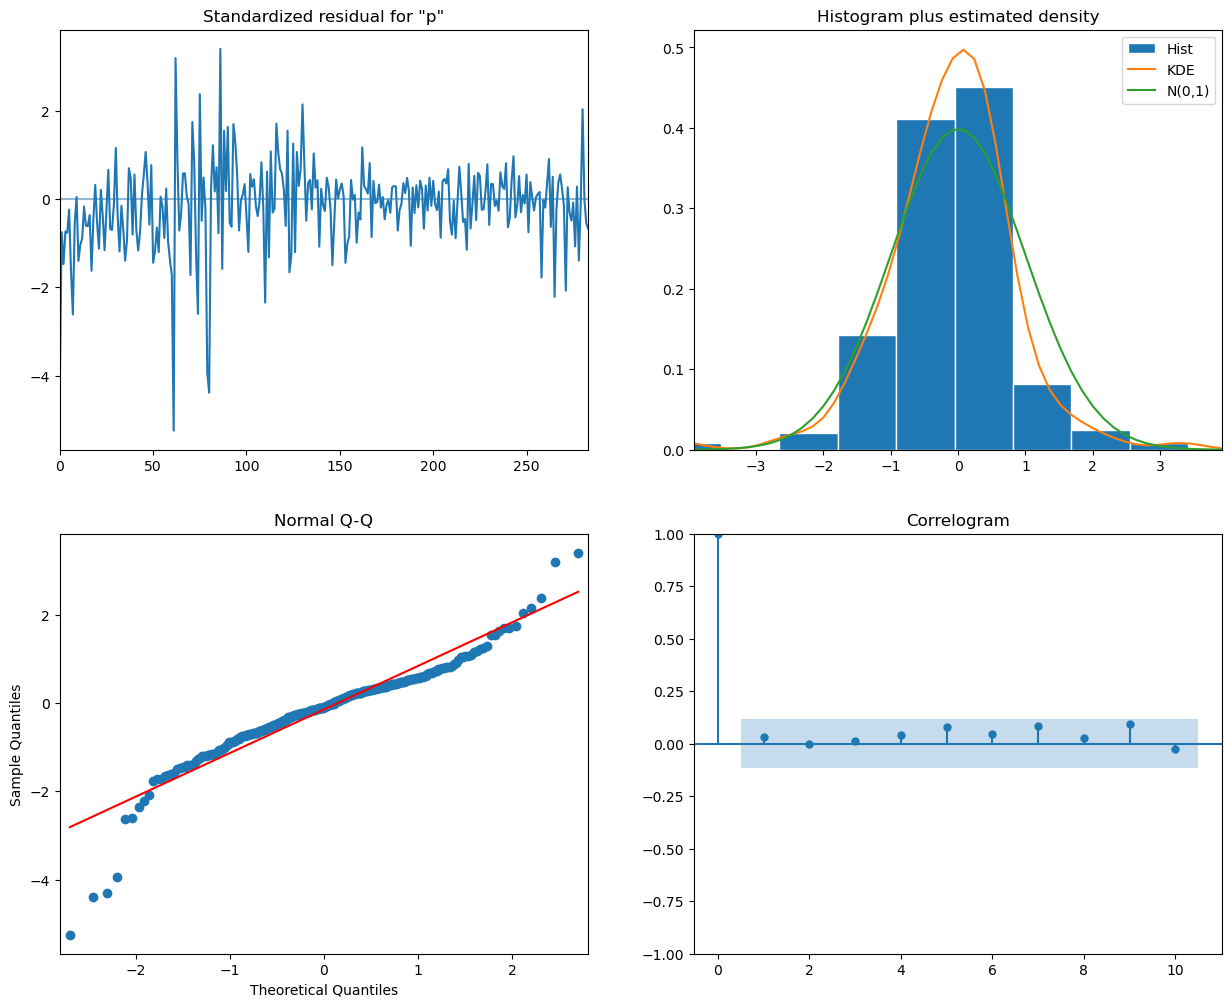

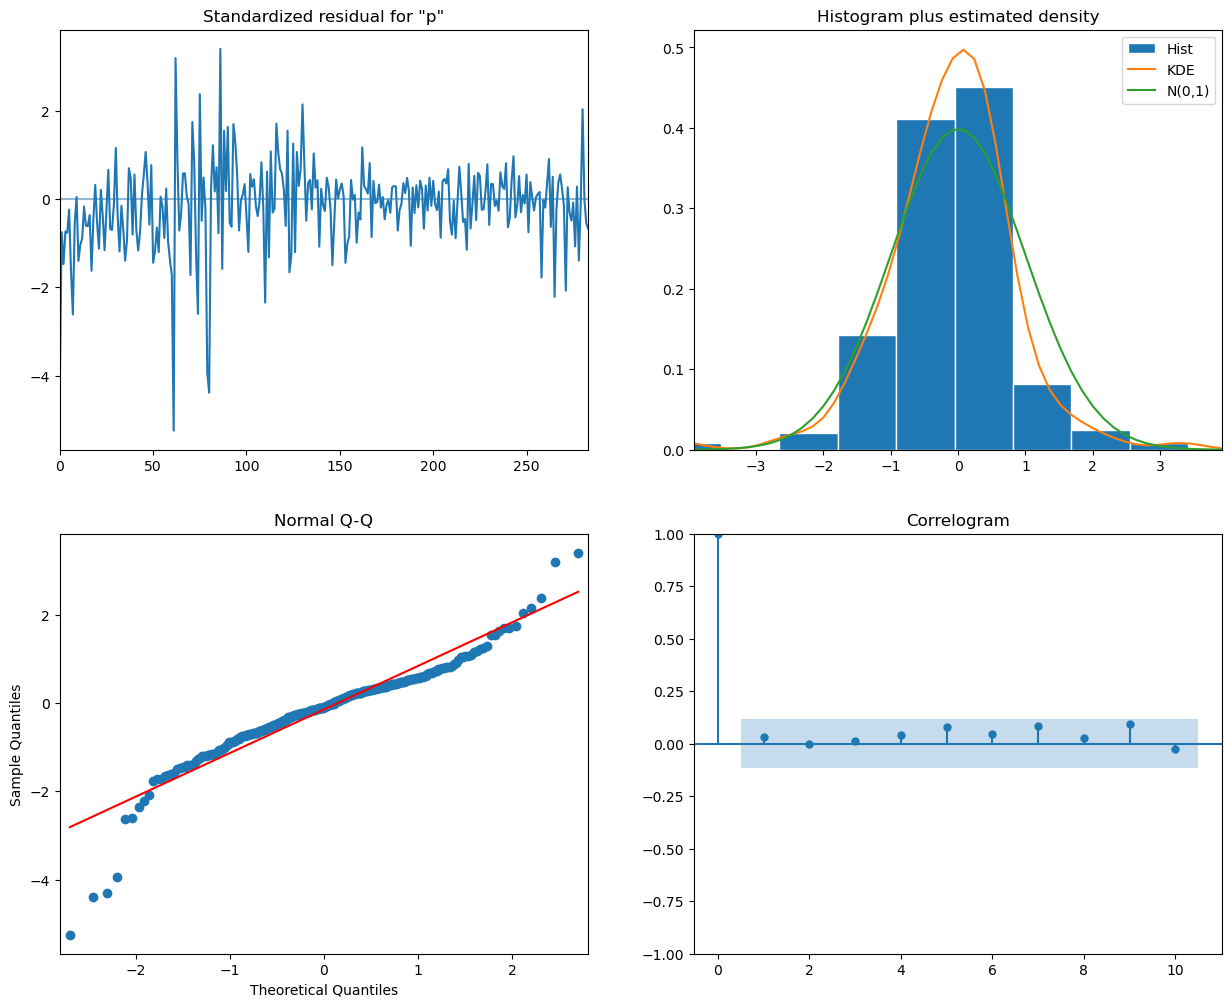

In [78]:
model.plot_diagnostics(figsize=(15, 12))

<Axes: >

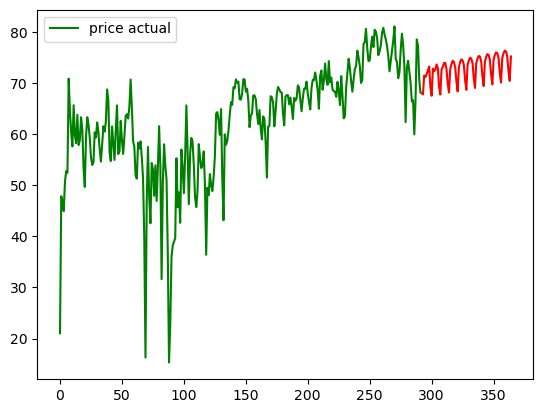

In [79]:
ax = train.plot( y="price actual", legend=True, color="green")
forecast_values.predicted_mean.plot(ax=ax, label="Forecast", color="red")

**Predict one step ahead of last 10 values**

In [82]:
# Pick the last 10 observations from the test set, which is the tail of the data. 
val_set10= test.tail(10)

In [83]:
val_set10.shape

(10,)

In [ ]:
pred_time = 1
result = model.predict(pred_time)